<a href="https://colab.research.google.com/github/Tommmster/6620_/blob/master/Copy_of_AS_g20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

### <font color=blue>Descripciones de archivos y campos de datos
<font color=blue>***train.csv*** : registros personales de aproximadamente dos tercios (~ 8700) de los pasajeros, que se utilizarán como datos de capacitación.

<font color=blue>**PassengerId**- Un Id único para cada pasajero.<br>
**HomePlanet**- El planeta del que partió el pasajero, normalmente su planeta de residencia permanente.<br>
**CryoSleep**- Indica si el pasajero eligió ser puesto en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.<br>
**Cabin**- El número de cabina donde se hospeda el pasajero. Toma la forma deck/num/side, donde side puede ser Ppor Babor o Spor Estribor . Babor y estribor son, respectivamente, los lados izquierdo y derecho de una embarcación, mirando hacia proa (la parte delantera del barco), independientemente del sentido de la marcha.<br>
**Destination**- El planeta al que desembarcará el pasajero.<br>
**Age**- La edad del pasajero.<br>
**VIP**- Si el pasajero ha pagado por servicio VIP especial durante el viaje.<br>
**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**- Monto que el pasajero ha facturado en cada uno de los muchos servicios de lujo del Spaceship Titanic .<br>
**Name**- El nombre y apellido del pasajero.<br>
**Transported**- Si el pasajero fue transportado a otra dimensión. Este es el objetivo, la columna que está tratando de predecir.<br>
***test.csv*** : registros personales del tercio restante (~4300) de los pasajeros, que se utilizarán como datos de prueba. Su tarea es predecir el valor de Transported para los pasajeros en este conjunto.<br>**PassengerId**- Id para cada pasajero en el conjunto de prueba.<br>**Transported**- El objetivo. Para cada pasajero, prediga True o False.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/AS/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AS/test.csv')
passengerId = df.PassengerId

Mounted at /content/drive


## Algún análisis exploratorio que permita tomar decisiones sobre las variabes a usar, transformaciones de variables, tratamiento de los datos faltantes, etc. etc.

###<font color=blue> Analisis Exploratorio y Transformacion de variables

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


[Text(0.5, 1.0, 'Gráfico de barras de Transported')]

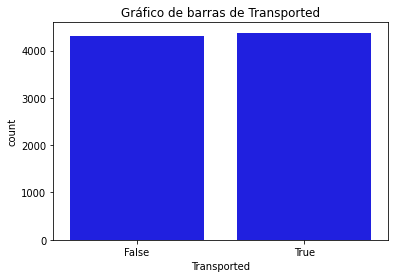

In [10]:
plt.figure(figsize = (6,4))
g = sns.countplot(x='Transported', data=df, color='blue')
g.set(title='Gráfico de barras de Transported')


<font color=blue> Como se puede apreciar las clases estan balanceadas.

<font color=blue> Para la visualizacion de los datos primero vamos a realizar una serie de separacion de columnas acorde a lo indicado, estas corresponderan a las columnas:Cabin, Name a los fines de realizar luego determinadas imputaciones que nos permitiran predecir el valor de la variable objetivo.

In [11]:
#Parseamos el campo Cabin,seatamos los campos nuevos, luego recorremos mediante un for el df y para todos aquellos caso que no sean nulos realizado el parseo del campo Cabin

for Dataset in (df, df_test):
 Dataset['Cabin_deck'] = np.NaN
 Dataset['Cabin_num'] = np.NaN
 Dataset['Cabin_side'] = np.NaN
 for i in range(len(Dataset)):
    if pd.isna(Dataset.iloc[i]['Cabin']):
        continue
    deck, num, side = Dataset.iloc[i]['Cabin'].split('/')
    Dataset.loc[i, 'Cabin_deck'] = deck
    Dataset.loc[i, 'Cabin_num'] = int(num)
    Dataset.loc[i, 'Cabin_side'] = side



In [12]:
#identificamos tipos de variables para el analisis exploratorio del conjunto train
variables_categoricas = []
variables_numericas = []
for columna in df.columns:
  if columna in ['PassengerId', 'Transported']:
    continue
  if df[columna].dtype == 'object':
     variables_categoricas += [columna]
  else:
     variables_numericas += [columna]
        

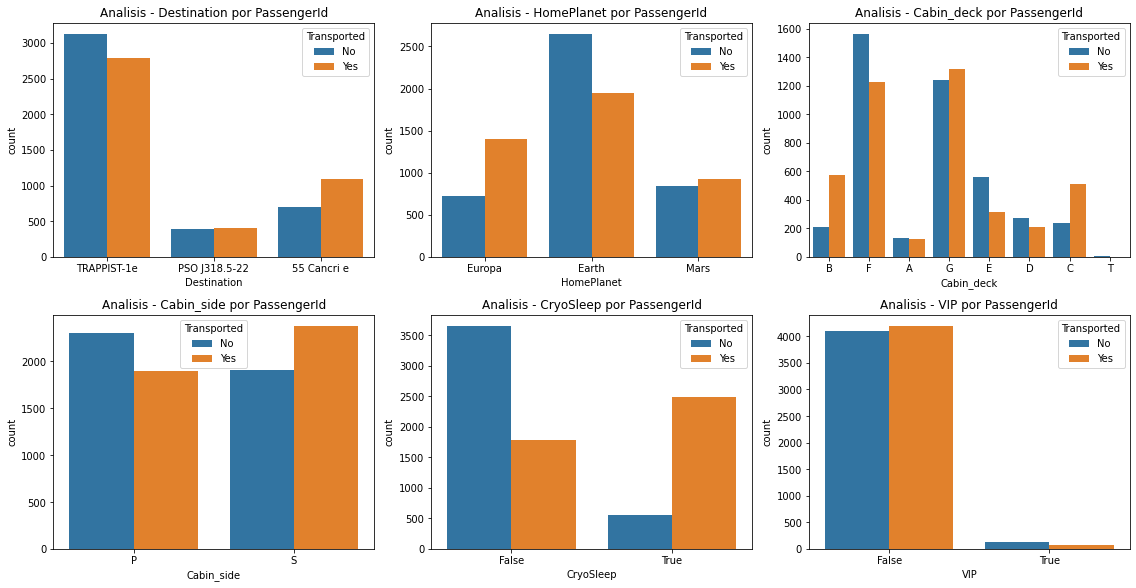

In [13]:
# veamos como es la distribucion de las clases para las variables mas interesantes
categoricas_columns=['Destination','HomePlanet','Cabin_deck','Cabin_side', 'CryoSleep', 'VIP']

plt.rcParams['figure.figsize'] = (16,20)
for i in range(len(categoricas_columns)):
 plt.subplot(5,3,i+1) 
 plt.tight_layout()
 df_column=df[['PassengerId', categoricas_columns[i],'Transported']].drop_duplicates(subset =['PassengerId', categoricas_columns[i]], keep = 'first')
 g = sns.countplot(x=categoricas_columns[i], data=df_column, hue='Transported')
 g.set(title='Analisis - '+ categoricas_columns[i] + ' por PassengerId')
 h, l = g.get_legend_handles_labels()
 plt.legend(title='Transported', handles=h, labels=['No', 'Yes'])

<font color=blue>Como se puede apreciar para algunas variables categoricas no se logra identificar algun comportamiento diferente que nos de indicios de que fue o No Transportado.<br> Por otro lado, para la variable CryoSleep cuando es False, es mayor la cantidad de personas no transportadas. Mientras que si es True es menor la cantidad de personas transportadas. Esto puede deberse a que las personas no CryoSleep no se encontraban en sus cabinas al momento del impacto.<br>Veamos algunas variables numericas.

In [14]:
df.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8494.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,999.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000


<font color=blue> Se puede apreciar para la variable Age su media y mediana son similares, mientras que los servicios de lujo RoomService, FoodCourt, ShoppingMall, Spa, VRDeck poseen una mediana de 0 dado que mas de la mitad de las personas no hicieron consumos de lujo.

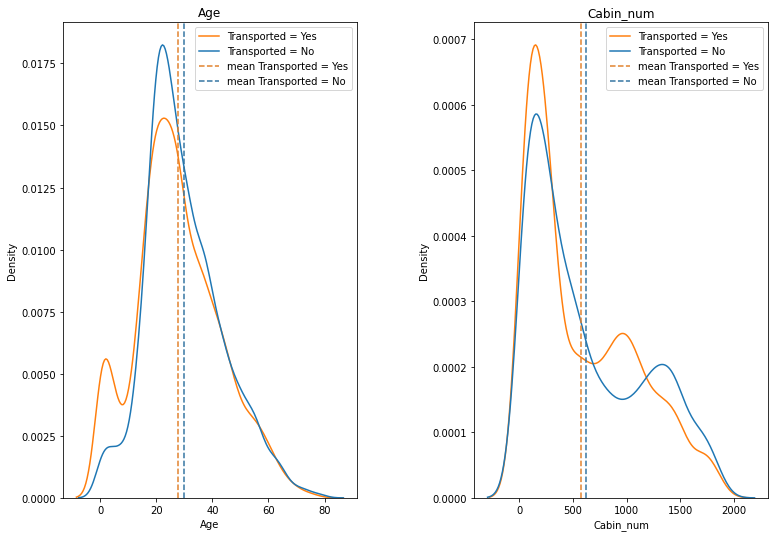

In [15]:
# veamos sus graficas, pero solo las mas interesantes
n_cols = len(variables_numericas)
cols_interest=['Age','Cabin_num' ] #, "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"
fig = plt.figure(figsize=(20, 35))
rows = int(n_cols / 3) + (n_cols % 3 > 0)

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(rows,3,i+1)
    ax.set_title(cols_interest[i])
    sns.kdeplot(data=df, x=coln, hue='Transported', legend=True)
    ax.axvline(df[(df.Transported == 1)][cols_interest[i]].mean(), color='#e1812c', linestyle='--')
    ax.axvline(df[(df.Transported == 0)][cols_interest[i]].mean(), color='#3274a1', linestyle='--')
    ax.legend(['Transported = Yes','Transported = No','mean Transported = Yes','mean Transported = No'], fontsize=10)
 
fig.subplots_adjust(hspace=.5,wspace=0.4)    

plt.show()   
plt.close()

<font color=blue> Tal como se indico antes la media en Age son bastante similares para ambas clases.<br> Por otro lado para el dato Cabin_num se observa tambien una media similar entre ambas clases, aqui la clase Transported tiene una mayor superficie para aquellos casos cuyo valor es menor a la media.

###<font color=blue> Datos Faltantes, deteccion de correlacion e imputacion de datos

In [16]:
#veamos los valores nulos
def status(data):
    data2=data
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)
status(df)


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.000000,0,0.000000,8693,object
1,HomePlanet,201,0.023122,0,0.000000,3,object
2,CryoSleep,217,0.024963,5439,0.625676,2,object
3,Cabin,199,0.022892,0,0.000000,6560,object
4,Destination,182,0.020936,0,0.000000,3,object
5,Age,179,0.020591,178,0.020476,80,float64
6,VIP,203,0.023352,8291,0.953756,2,object
7,RoomService,181,0.020821,5577,0.641551,1273,float64
8,FoodCourt,183,0.021051,5456,0.627631,1507,float64
9,ShoppingMall,208,0.023927,5587,0.642701,1115,float64


<font color=blue> La perdida de datos no es significativa en su mayoria no supera el 3% por variable. Veamos graficamente la perdida de los datos.

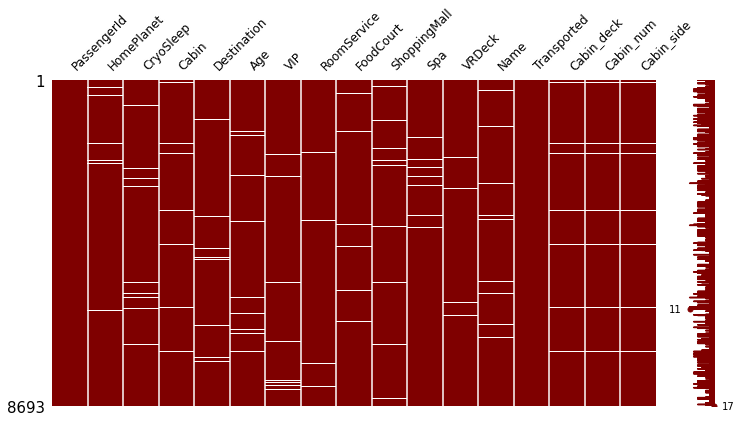

In [17]:
import missingno as msno
msno.matrix(df,figsize=(12, 6), fontsize=12, color=[0.5,0,0])

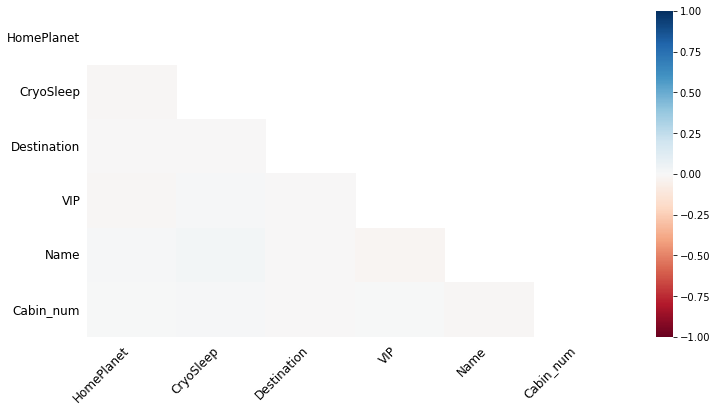

In [18]:
# veamos su correlacion a fin de analizar si la faltante de datos esta relacionada , solo analizaremos las variables mas relavantes
variables_nulas=['HomePlanet','CryoSleep','Destination','VIP','Name' ,'Cabin_num'] 
msno.heatmap(df[variables_nulas],figsize=(12, 6), fontsize=12)

<font color=blue> Como se puede apreciar no existe correlacion de perdida de datos entre las variables.<br> Las variables que descartaremos son:<br> 
PassengerId, dado que no es una variable que explique el comportamiento de las clases.<br>
Cabin,dado que esta parseada en Cabin_side, Cabin_num y Cabin_deck.<br>
Name, dado que no nos ha sido util para nuestro analisis, no nos explica el comportamiento de las clases. <br>

##<font color=blue> Preprocesamiento de Datos
<font color=blue>Realizaremos una transformacion de las variables categoricas y booleanas y un OneHotEncoding de los datos para disponibilizarlos para el modelo. 

###<font color=blue> Transformacion de Variables

In [19]:
# Eliminacion de caracteristicas
 
df_bck = df.copy(deep=True)
df_test_bck=df.copy(deep=True)
drop_vars = ['PassengerId', 'Name', 'Cabin']

df = df.drop(drop_vars, axis=1)
df_test = df_test.drop(drop_vars, axis=1)



In [20]:
# imputacion de datos
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService", "Cabin_num"]
imputer = SimpleImputer(strategy="median")
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])


In [21]:
# imputacion de bools, numericas y categoricas
def cols(df):
  vs = df.columns.to_series().groupby(df.dtypes).groups
  numerical = vs[np.dtype('float64')]
  categorical = vs[np.dtype('O')]
  c_a = df.columns
  c_c = categorical
  c_n = numerical
  return c_a, c_c, c_n

In [22]:
def nor_num(df):
  c_a, c_c, c_n = cols(df)
  for col in c_n:
    mu = df[col].mean()
    st = df[col].std()
    for i in range(len(df[col])):
      df[col][i] = (df[col][i] - mu) / st

In [23]:
def imp_bool(df,col):
  for i in range(len(df[col])):
    ps = df[col][i]
    if str(ps)=='True':
      df[col][i] = 1.0
    if str(ps)=='False':
      df[col][i] =-1.0
    if not (str(ps)=='True' or str(ps)=='False'):
      df[col][i] = 0.0
  df[col] = df[col].astype('float64')

In [ ]:
#imputamos los dfs
# train
nor_num(df)
imp_bool(df,'CryoSleep')
imp_bool(df,'VIP')

#test
nor_num(df_test)
imp_bool(df_test,'CryoSleep')
imp_bool(df_test,'VIP')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# Imputamos por Cabin_deck en forma separada dado que es una variable categorica y no en el OneHotEncode
Te = LabelEncoder()
for dataset in (df, df_test):
    dataset['Cabin_deck'] = Te.fit_transform(dataset['Cabin_deck'])

####<font color=blue> OneHotEncode

In [ ]:
#despues de la eliminacion de caracteristicas volvemos a identificamos tipos de variables 
def encode(df):
 variables_categoricas = []
 variables_numericas = []
 for columna in df.columns:
  if df[columna].dtype == 'object':
     variables_categoricas += [columna]
  else:
     variables_numericas += [columna]

  #aplicamos OneHotEnconde , creamos un df para cada tipo de variable
 from sklearn.preprocessing import OneHotEncoder
 df_cat = df[variables_categoricas]
 df_num = df[variables_numericas]

 #valores de las variables categoricas
 categorias = [df_cat[col].value_counts().index.values for col in variables_categoricas]

 encoder = OneHotEncoder(categories=categorias, handle_unknown="ignore")
 encoder.fit(df_cat)

 et = encoder.transform(df_cat).toarray()#.todense()
 #agregamos las columnas numericas
 dat_enc = np.hstack([et, df_num])
 #obtenemos la matriz 
 dat_enc.shape

 #Creamos un dataframe a partir de la matriz generada
 ohc = encoder.get_feature_names_out(df_cat.columns)
 cols = np.append(ohc, df_num.columns)
 oh_df = pd.DataFrame(dat_enc, columns = cols)
 return oh_df



In [ ]:
#train
df_enc = encode(df)
df_test = encode(df_test)
df_enc.isnull().sum().reset_index()
#df_enc[:10]


In [ ]:
# Convertimos los valores de la variable objetivo en numéricas, para satisfacer a accuracy_score
y =df_enc.Transported.apply(lambda b: 1 if b else -1)
X =df_enc.drop('Transported',axis=1)
X
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

In [ ]:
y_train.values

In [ ]:
X[:5]

# Planteo modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

## Modelo 1: XGB

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier

clfs =  [XGBClassifier()]

names = [ 'XGBoost']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train.values, y_train.values)
    train_predictions = clf.predict(x_train.values)
    accuracy = accuracy_score(y_train.values, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(x_test.values)
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

In [ ]:
models = pd.DataFrame({'Model':names, 'Score':accuracy_models})
models.sort_values(by='Score', ascending=False)

### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

###<font color = blue>Hiperparametros ajustados para el Modelo seleccionado:
<font color= blue> **learning_rate:** también llamado eta , especifica la rapidez con la que el modelo ajusta los errores residuales mediante el uso de aprendices de base adicionales.<br> **max_depth:** nivel de profundidad.<br>**sub_sample y colsample_bytree:** a los fines de controlar el sobreajuste se utiliza este parametro, dado que permite agregar aleatoriedad para que el entrenamiento sea resistente al ruido.

In [ ]:
# Los valores de x_train son object. 
# Algunas funciones se quejan con el mensaje
# """DataFrame.dtypes for data must be int, float or bool. 
# Por lo que los tratamos como valores float.
x_train.dtypes

In [ ]:
x_train_f = x_train.astype(float)
x_test_f = x_test.astype(float)

In [ ]:
# Init classifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(x_train_f, y_train)

# Predict
preds = xgb_cl.predict(x_test_f)

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve

param_grid = {
    "max_depth":[3,5],
    "learning_rate":[0.2, 0.5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

grid_cv.fit(x_train_f, y_train)


In [ ]:
grid_cv.best_params_

In [ ]:
 grid_cv.best_score_

In [ ]:
model1 = grid_cv.best_estimator_
score1 = grid_cv.best_score_

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.values, model1.predict_proba(x_test_f)[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

<font color=blue> Como se puede apreciar el modelo mejoro sustancialmente principalmente al ajustarlo indicando el parametro objective, que por defecto es reg:squarederror: regresión con pérdida al cuadrado por el de binary:logistic: regresión logística para clasificación binaria, probabilidad de salida que se ajusta a nuestro modelo.

## Modelo 2: NN

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

## Modelo 3: RF
Entrenamos un árbol de desición y un _random forest_

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df_train.values, TARGET_COLUMN.values, test_size=0.33, random_state=42)
x_train, x_test, y_train, y_test
X_train = x_train
X_test = x_test

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
X = X_train
y = y_train

In [ ]:
print(X.shape)
print(y.shape)

Realizamos un análisis sobre distintos valores del hiperparámetro `max_depth`, con el objetivo de tener un valor aproximado. El resto de los hiperparámetros tienen el valor _default_ 

(Valores en https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [ ]:
def train_tree(features, target):
  """
  Retorna una función que permite evaluar el conjunto de entrenamiento, dado 
  un valor para max_depth
  """
  
  def run_with(max_depth):
    clf = DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(features, target)
    return clf

  return run_with

def eval(p, X_test, y_test):
  """
  Retorna el accuracy_score del clasificador p, sobre los valores de entrenamiento
  """
  y_pred = p.predict(X_test)
  return accuracy_score(y_test, y_pred), p.score(X_test, y_test)


build_tree = train_tree(X, y)
e = {}

b = build_tree(max_depth = None)
acc_score, score = eval(b, X_test, y_test)

print(f"Depth: None, accuracy_score: {acc_score}, score: {score}")
e[0] = acc_score

for d in range(1, 100):
  candidate_tree = build_tree(d)

  acc_score, score = eval(candidate_tree, X_test, y_test)
  print(f"Depth: {d}, accuracy_score: {acc_score}, score: {score}")
  
  
  e[d] = acc_score

In [ ]:
d = max(e, key=e.get)
depth = None if d == 0 else d

print(f"El arbol con mayor accuracy tiene profundidad {depth}")
tree_pred = build_tree(depth)

eval(tree_pred, X_test, y_test)

In [ ]:
def class_names(p):
  class_names = map(lambda b: str(b), p.classes_)
  return list(class_names)

classes = class_names(tree_pred)

In [ ]:
dot_data = export_graphviz(tree_pred, out_file=None, 
                           feature_names=x_train.columns, 
                           class_names = classes,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Búsqueda de hiperparámetros
Utilizamos búsqueda con validación cruzada para encontrar el mejor conjunto de hiperparámetros, utilizando un conjunto acotado de valores

In [ ]:
params = [
    {
        'max_leaf_nodes': list(range(2, 10)), 
        'min_samples_split': list(range(2, 25)),
        'max_depth': [None] + list(range(2, 50))
    },
    
    {
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion' :['gini', 'entropy']
    }
]


tree = DecisionTreeClassifier()
clf = GridSearchCV(tree, params)
clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_

Podemos obtener los parámetros que obtuvieron el mejor resultado, así como la media de resultados obtenidos al relizar cross validation

In [ ]:
clf.best_params_, clf.best_score_

In [ ]:
best_tree = clf.best_estimator_

best_tree


In [ ]:
# accuracy_score
eval(best_tree, X_test, y_test)

In [ ]:
dot_data = export_graphviz(best_tree, out_file=None, 
                           feature_names=x_train.columns, 
                           class_names = class_names(best_tree),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Performance

#### Confusion matrix

In [ ]:
# Obtenemos un conjunto de predicciones para comparar con los valores objetivos
# Usamos los conjuntos de entrenamiento (no los de test)
y_train_pred = cross_val_predict(best_tree, X_train, y_train, cv= 3)

cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names(best_tree))
p = disp.plot()


#### Recall
¿Cuál es el total de predicciones positivas que fueron clasificadas correctamente? Es decir, que porcentaje de personas transportadas fué reconocido como tal.

In [ ]:
recall_score(y_train, y_train_pred)

#### Precisión
¿ Cuál es el porcentaje de positivos verdaderos? De aquellas personas que fueron identificadas como transportadas, ¿Qué porcentaje es verdadero?

In [ ]:
precision_score(y_train, y_train_pred)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train.values, y.values, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
X = X_train
y = y_train

In [ ]:
print(X.shape)
print(y.shape)

Realizamos un análisis sobre distintos valores del hiperparámetro `max_depth`, con el objetivo de tener un valor aproximado. El resto de los hiperparámetros tienen el valor _default_ 

(Valores en https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [ ]:
def train_tree(features, target):
  """
  Retorna una función que permite evaluar el conjunto de entrenamiento, dado 
  un valor para max_depth
  """
  
  def run_with(max_depth):
    clf = DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(features, target)
    return clf

  return run_with

def eval(p, X_test, y_test):
  """
  Retorna el accuracy_score del clasificador p, sobre los valores de entrenamiento
  """
  y_pred = p.predict(X_test)
  return accuracy_score(y_test, y_pred), p.score(X_test, y_test)


build_tree = train_tree(X, y)
e = {}

b = build_tree(max_depth = None)
acc_score, score = eval(b, X_test, y_test)

print(f"Depth: None, accuracy_score: {acc_score}, score: {score}")
e[0] = acc_score

for d in range(1, 100):
  candidate_tree = build_tree(d)

  acc_score, score = eval(candidate_tree, X_test, y_test)
  print(f"Depth: {d}, accuracy_score: {acc_score}, score: {score}")
  
  
  e[d] = acc_score

In [ ]:
d = max(e, key=e.get)
depth = None if d == 0 else d

print(f"El arbol con mayor accuracy tiene profundidad {depth}")
tree_pred = build_tree(depth)

eval(tree_pred, X_test, y_test)

In [ ]:
def class_names(p):
  class_names = map(lambda b: str(b), p.classes_)
  return list(class_names)

classes = class_names(tree_pred)

In [ ]:
dot_data = export_graphviz(tree_pred, out_file=None, 
                           feature_names=x_train.columns, 
                           class_names = classes,
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Búsqueda de hiperparámetros

In [ ]:
params = [
    {
        'max_leaf_nodes': list(range(2, 10)), 
        'min_samples_split': list(range(2, 25)),
        'max_depth': [None] + list(range(2, 50))
    },
    
    {
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion' :['gini', 'entropy']
    }
]


tree = DecisionTreeClassifier()
clf = GridSearchCV(tree, params)
clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_

Podemos obtener los parámetros que obtuvieron el mejor resultado, así como la media de resultados obtenidos al relizar cross validation

In [ ]:
clf.best_params_, clf.best_score_

In [ ]:
best_tree = clf.best_estimator_

best_tree


In [ ]:
# accuracy_score
eval(best_tree, X_test, y_test)

In [ ]:
dot_data = export_graphviz(best_tree, out_file=None, 
                           feature_names=x_train.columns, 
                           class_names = class_names(best_tree),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Performance

#### Confusion matrix

In [ ]:
# Obtenemos un conjunto de predicciones para comparar con los valores objetivos
# Usamos los conjuntos de entrenamiento (no los de test)
y_train_pred = cross_val_predict(best_tree, X_train, y_train, cv= 3)

cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names(best_tree))
p = disp.plot()


#### Recall
¿Cuál es el total de predicciones positivas que fueron clasificadas correctamente? Es decir, que porcentaje de personas transportadas fué reconocido como tal.

In [ ]:
recall_score(y_train, y_train_pred)

#### Precisión
¿ Cuál es el porcentaje de positivos verdaderos? De aquellas personas que fueron identificadas como transportadas, ¿Qué porcentaje es verdadero?

In [ ]:
precision_score(y_train, y_train_pred)

## Random forest

In [ ]:
forest_clf = RandomForestClassifier()

In [ ]:
param_grid = [
    {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None] + list(range(2, 50)),
     },
     {
    'n_estimators': [50, 100, 200, 400],
    'criterion' :['gini', 'entropy']
    }
]

In [ ]:
cv_rfc = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv= 5)
cv_rfc.fit(X_train, y_train)

In [ ]:
cv_rfc.best_params_, cv_rfc.best_score_

In [ ]:
best_forest = cv_rfc.best_estimator_
best_forest

In [ ]:
y_train_pred = cross_val_predict(best_forest, X_train, y_train, cv= 3)

cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names(best_forest))
p = disp.plot()


#### Precision  / Recall

In [ ]:
precision_score(y_train, y_train_pred)

In [ ]:
recall_score(y_train, y_train_pred)

# Generamos la salida para entregar

In [ ]:
if score1 < score2:
  best_model = model2
if score2 < score1:
  best_model = model1

In [ ]:
test_id = passengerId
test_pred = best_model.predict(df_test)

In [ ]:
submission_csv = "sample_submission.csv"
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv(submission_csv, header=True, index=False)
submission

from google.colab import files
files.download(submission_csv)